In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# reading docfiles
import docx2txt

#nltk
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(['ja', 'ne', 'ok', 'okay', 'genau', 'also', 'mhm'])

In [3]:
os.chdir('input/app_v1')

path_v1 = ("C:\\Users\\vanandkuma\\Documents\\projects\\sentiment_analysis\\input\\app_v1")

In [4]:
files = []
for file in os.listdir(path_v1):
    if file.endswith('.docx'):
        files.append(file)

In [5]:
pooled_doc = []
for i in range(len(files)):
    text = docx2txt.process(files[i])
    pooled_doc.append(text) 

In [6]:
df = []
for i in range(len(pooled_doc)):
    sentence = nltk.tokenize.sent_tokenize(pooled_doc[i])
    for i in range(len(sentence)):
        df.append(sentence[i])

In [7]:
for i in range(len(df)):
    df[i] = df[i].replace('\n', '')

In [ ]:
print(df)

In [9]:
df = pd.DataFrame(df, columns=['text'])

In [10]:
df['text_processed'] = \
df['text'].map(lambda x: re.sub('[,.!?]', '', x))

In [11]:
df['text_processed'] = \
df['text_processed'].map(lambda x: x.lower())

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc = True))

In [13]:
data = df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['ich', 'finde', 'den', 'inhalt', 'und', 'den', 'aufbau', 'der_app', 'gut', 'und', 'selbsterklarend']


In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [17]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [18]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("de_core_news_sm", disable = ['parser', 'ner'])

In [19]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['finden', 'Inhalt', 'Aufbau', 'app', 'gut', 'selbsterklarend']]


In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [21]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('Aufbau', 1),
  ('Inhalt', 1),
  ('app', 1),
  ('finden', 1),
  ('gut', 1),
  ('selbsterklarend', 1)]]

In [22]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"Hebammen" + 0.030*"geben" + 0.019*"brauchen" + 0.018*"mögen" + '
  '0.016*"folgend" + 0.016*"Betreuung" + 0.012*"Unterstutzung" + '
  '0.012*"empfehlen" + 0.011*"schaden" + 0.011*"fachkrafen"'),
 (1,
  '0.028*"gut" + 0.018*"schon" + 0.016*"umsetzen" + 0.015*"Wiederholung" + '
  '0.015*"helfen" + 0.015*"Frage" + 0.014*"sagen" + 0.012*"mal" + '
  '0.012*"lernen" + 0.012*"Praxis"')]


In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.100517053510941

Coherence Score:  0.5441100077946905


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.111003  0.0       1        1  58.623564
0     -0.111003  0.0       2        1  41.376436, topic_info=                Term        Freq       Total Category  logprob  loglift
311         Hebammen  405.000000  405.000000  Default  30.0000  30.0000
126            geben  240.000000  240.000000  Default  29.0000  29.0000
4                gut  319.000000  319.000000  Default  28.0000  28.0000
47          brauchen  154.000000  154.000000  Default  27.0000  27.0000
1061           mögen  147.000000  147.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
4409  zuruckzufuhren   80.546890  144.561977   Topic2  -4.6040   0.2976
4410     Bewaltigung   62.977616  149.386174   Topic2  -4.8501   0.0187
4411        schulung   62.977616  149.386174   Topic2  -4.8501   0.0187
2860          Umgang   63.013748  155.473532   Topic2  -4.8495  -0.0207
464          Lektion   53.854287  114.403966   Topic2  -5.0066   0.1290

[128 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1595      1  0.200735         Antwort
1595      2  0.802942         Antwort
486       1  0.993173        Beispiel
486       2  0.013242        Beispiel
4403      1  0.442717         Beitrag
...     ...       ...             ...
928       2  0.021307        wirklich
133       1  0.017849          wissen
133       2  0.981701          wissen
4409      1  0.442717  zuruckzufuhren
4409      2  0.560313  zuruckzufuhren

[171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=1, 
                                                        limit=6, 
                                                        step=1)

In [29]:
os.chdir("C:\\Users\\vanandkuma\\Documents\\projects\\sentiment_analysis")

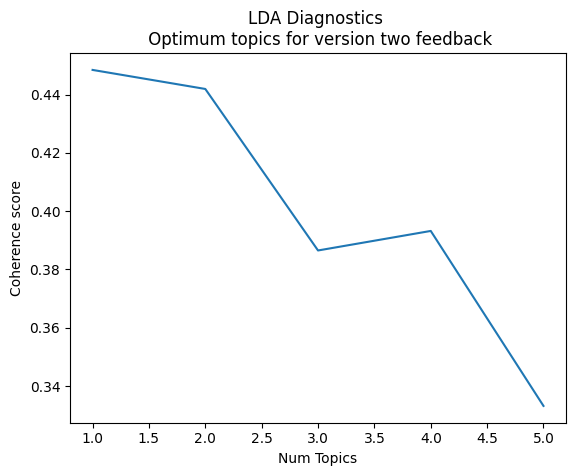

In [30]:
# Show graph
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.title("LDA Diagnostics \n Optimum topics for version two feedback")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.savefig('output/app_v1_lda_topic_coherence.png')

In [32]:
pyLDAvis.save_html(vis, 'output/ldavis_app_v1.html')